In [1]:
import os
import gc
from joblib import dump, load, Parallel, delayed
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# load files

In [2]:
train = pd.read_parquet("../input/train_full_features.parquet")

# define loss and metric

In [3]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# define training config

In [31]:
exclude_features = []

exclude_features += [
    "customer_ID", 
    "target",
]

features = [col for col in train.columns if col not in exclude_features]
# features = [col for col in features if ("D_66" not in col) and ("D_87" not in col)]

cat_features_base = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
] 
cat_features = []
for feature in features:
    for cat_feature_base in cat_features_base:
        if cat_feature_base in feature:
            cat_features.append(feature)
            
target = "target"

In [32]:
base_stat_agg_group_1_to_del = load("base_stat_agg_group_1_to_del.pkl")[0]
base_stat_agg_group_2_to_del = load("base_stat_agg_group_2_to_del.pkl")[0]
base_stat_agg_to_del = base_stat_agg_group_1_to_del + base_stat_agg_group_2_to_del

sma_agg_to_del = load("sma_agg_to_del.pkl")[0]

# quantile_agg_to_del = load("quantile_agg_to_del.pkl")[0]
quantile_agg_to_del = [feature for feature in features if "quantile" in feature]

# skew_agg_to_del = load("skew_agg_to_del.pkl")[0]
# skew_agg_to_del = []
skew_kurtosis_agg_to_del = load("skew_kurtosis_agg_to_del.pkl")[0]
skew_kurtosis_agg_to_del = [feature for feature in features if "skew" in feature] + \
    [feature for feature in features if "kurtosis" in feature]

features = [feature for feature in features if feature not in (base_stat_agg_to_del + \
                                                               sma_agg_to_del + \
                                                               quantile_agg_to_del + \
                                                               skew_kurtosis_agg_to_del)]

In [33]:
skew_kurtosis_features = [feature for feature in features if "skew" in feature or "kurtosis" in feature]

In [34]:
len(skew_kurtosis_features)

0

In [35]:
seed = 42
n_folds = 5

xgb_parms = { 
    "max_depth":4, 
    "learning_rate":0.05, 
    "subsample":0.8,
    "colsample_bytree":0.6, 
    "eval_metric":"logloss",
    "objective":"binary:logistic",
    "tree_method":"gpu_hist",
    "gpu_id":1,
    "predictor":"gpu_predictor",
    "random_state":seed
}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(seed)

In [36]:
def training(train):

    importances = []
    
    # create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))

    kfold = StratifiedKFold(
        n_splits=n_folds, 
        shuffle=True, 
        random_state=seed
    )
    
    for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

        print("#"*100)
        print("Training fold {} with {} features...".format(fold, len(features)))
        
        x_train= train.loc[trn_ind, features]
        y_train= train.loc[trn_ind, target]
        x_val = train.loc[val_ind, features]
        y_val = train.loc[val_ind, target]

        # xgb_train = xgb.DeviceQuantileDMatrix(xy_train, max_bin=256)
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_val = xgb.DMatrix(data=x_val, label=y_val)

        model = xgb.train(
            xgb_parms, 
            dtrain=xgb_train,
            evals=[(xgb_train,"train"),(xgb_val,"valid")],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100
        ) 
        model.save_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

        # importance
        importance = model.get_score(importance_type="weight")
        importances.append(pd.DataFrame({"feature":importance.keys(), "importance_{}".format(fold):importance.values()}))

        # oof
        oof_preds = model.predict(xgb_val)
        score = amex_metric_mod(y_val.values, oof_preds)
        print("fold {} score is {}".format(fold, score))
        
        # add to out of folds array
        oof_predictions[val_ind] = oof_preds

        del x_train, y_train, x_val, y_val, xgb_train, xgb_val, model, importance, oof_preds
        _ = gc.collect()
    
    # compute oof
    score = amex_metric_mod(train[target], oof_predictions)
    print("oof score is {}".format(score))
    
    # create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({"customer_ID": train["customer_ID"], "target": train[target], "prediction": oof_predictions})
    oof_df.to_parquet("xgb_oof_{}.parquet".format(seed))
    
    return importances, oof_df

In [37]:
importances, oof_df = training(train)

####################################################################################################
Training fold 0 with 945 features...
[0]	train-logloss:0.66203	valid-logloss:0.66207
[100]	train-logloss:0.23674	valid-logloss:0.23955
[200]	train-logloss:0.22237	valid-logloss:0.22752
[300]	train-logloss:0.21636	valid-logloss:0.22362
[400]	train-logloss:0.21228	valid-logloss:0.22147
[500]	train-logloss:0.20907	valid-logloss:0.22035
[600]	train-logloss:0.20639	valid-logloss:0.21956
[700]	train-logloss:0.20403	valid-logloss:0.21910
[800]	train-logloss:0.20179	valid-logloss:0.21869
[900]	train-logloss:0.19965	valid-logloss:0.21836
[1000]	train-logloss:0.19773	valid-logloss:0.21817
[1100]	train-logloss:0.19579	valid-logloss:0.21794
[1200]	train-logloss:0.19397	valid-logloss:0.21777
[1300]	train-logloss:0.19218	valid-logloss:0.21767
[1400]	train-logloss:0.19043	valid-logloss:0.21752
[1500]	train-logloss:0.18875	valid-logloss:0.21744
[1600]	train-logloss:0.18704	valid-logloss:0.21736
[1700]	

In [11]:
importance = importances[0].copy()
for k in range(1, n_folds): 
    importance = importance.merge(importances[k], on="feature", how="left")
    
importance["importance"] = importance.iloc[:,1:].mean(axis=1)
importance = importance.sort_values("importance",ascending=False)

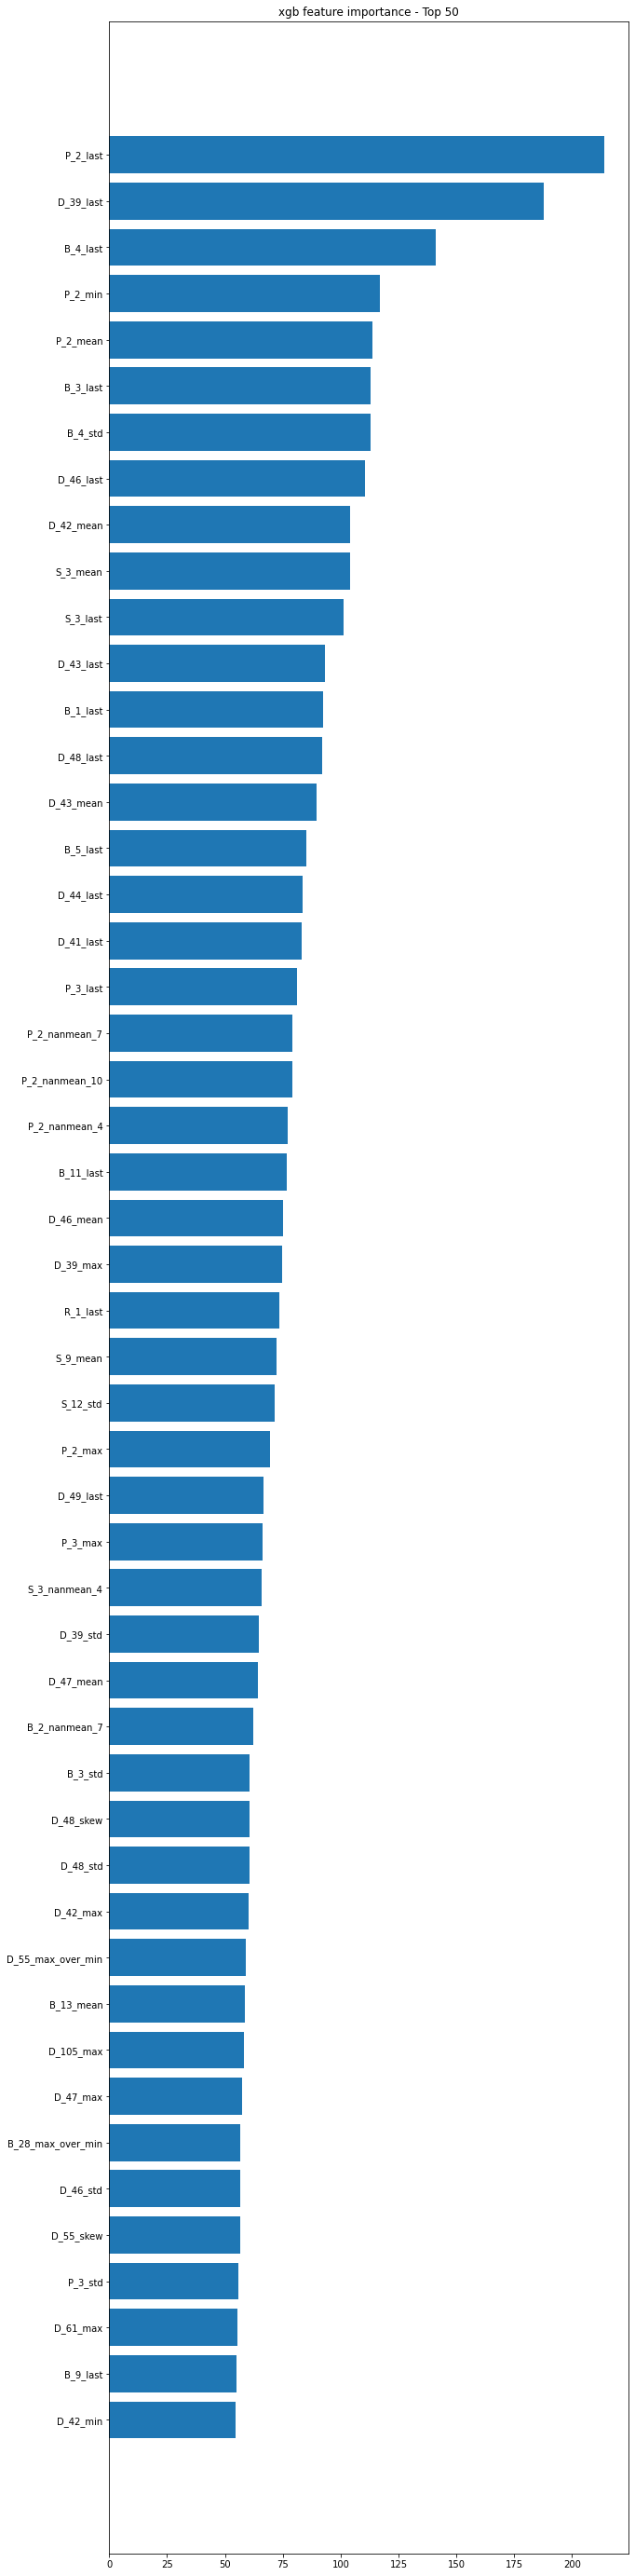

In [12]:
n_features = 50

plt.figure(figsize=(10, n_features))
plt.barh(np.arange(n_features, 0, -1), importance.importance.values[:n_features])
plt.yticks(np.arange(n_features,0,-1), importance.feature.values[:n_features])
plt.title("xgb feature importance - Top {}".format(n_features))
plt.show()

# permutation importance

In [13]:
kfold = StratifiedKFold(
    n_splits=n_folds, 
    shuffle=True, 
    random_state=seed
)
k_splits = kfold.split(train, train[target])

all_val_inds = []
all_models = []
all_features = []
all_targets = []

for fold,(trn_ind, val_ind) in enumerate(k_splits):

    all_val_inds.append(val_ind)

    model = xgb.Booster()
    model.load_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))
    # model.set_param({"predictor": "gpu_predictor"})
    all_models.append(model)

    features_fold = train.loc[val_ind, features]
    target_fold = train.loc[val_ind, target]

    all_features.append(features_fold)
    all_targets.append(target_fold)

In [14]:
def permutation(feature):
        
    oof_predictions = np.zeros(len(train))

    for fold, val_ind in enumerate(all_val_inds):

        x_val = all_features[fold].copy()
        x_val[feature] = np.random.RandomState(seed=42).permutation(x_val[feature])
        y_val = all_targets[fold].copy()

        xgb_val = xgb.DMatrix(data=x_val, label=y_val)

        # oof
        oof_preds = all_models[fold].predict(xgb_val)
        oof_predictions[val_ind] = oof_preds

    # compute oof
    score = amex_metric_mod(train[target], oof_predictions)
    
    return (feature, score)

In [15]:
permutation_importances = Parallel(n_jobs=10, verbose=1)(
        delayed(permutation)(feature) for feature in skew_kurtosis_features)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.2min
[Parallel(n_jobs=10)]: Done 354 out of 354 | elapsed: 15.7min finished


In [16]:
permutation_importances = sorted(permutation_importances, key=lambda x : x[1])

In [17]:
len(permutation_importances)

354

In [18]:
permutation_importances

[('D_62_kurtosis', 0.7915249494214953),
 ('B_29_kurtosis', 0.7915259097172266),
 ('D_46_kurtosis', 0.791526933808306),
 ('D_73_kurtosis', 0.7915309834219506),
 ('B_7_skew', 0.791540035201294),
 ('D_48_kurtosis', 0.7915438928160023),
 ('B_24_skew', 0.7915447750390954),
 ('D_115_kurtosis', 0.7915453062507877),
 ('P_2_skew', 0.7915522317777953),
 ('B_3_skew', 0.7915550165067265),
 ('B_28_kurtosis', 0.7915582910688963),
 ('D_50_kurtosis', 0.7915618157578276),
 ('B_11_kurtosis', 0.7915752586137643),
 ('D_74_skew', 0.7915813382687092),
 ('D_123_kurtosis', 0.7915826623988949),
 ('B_24_kurtosis', 0.7915828129476025),
 ('B_37_kurtosis', 0.7915857599801392),
 ('B_13_kurtosis', 0.7915860137197333),
 ('D_92_skew', 0.7915879395333012),
 ('S_27_kurtosis', 0.7915885067479467),
 ('R_6_skew', 0.7915891151398007),
 ('D_124_kurtosis', 0.7915901472211914),
 ('D_134_skew', 0.7915931186527179),
 ('S_3_kurtosis', 0.7915962900264624),
 ('D_55_kurtosis', 0.7915973474743756),
 ('D_79_skew', 0.7916033307945582),

In [19]:
dump(permutation_importances, "skew_kurtosis_agg_permutation_importances.pkl")

['skew_kurtosis_agg_permutation_importances.pkl']

In [20]:
features_to_del = []
feature_scores_to_del = []

for (feature, feature_score) in permutation_importances:
    if feature_score > 0.79168:
        features_to_del.append(feature)
        feature_scores_to_del.append(feature_score)

In [21]:
len(features_to_del)

191

In [22]:
dump([features_to_del, feature_scores_to_del], "skew_kurtosis_agg_to_del.pkl")

['skew_kurtosis_agg_to_del.pkl']